# LSTM Modelling 

In [1]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import GroupKFold

import warnings
warnings.filterwarnings("ignore")

2023-06-07 15:59:25.886964: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-07 15:59:26.001271: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-07 15:59:26.002517: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 15:59:26.952012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Refactor

In [2]:
dataset = pd.read_csv("../DateDatasets/dataset.csv").drop(columns=["Unnamed: 0"])

In [3]:
trips = pd.read_csv("../CSVFiles/datatrips.csv").drop(columns=["Unnamed: 0"])

day = []
year = []
for trip in trips.values:
    date = datetime.strptime(trip[0], "%Y-%m-%d %H:%M:%S").timetuple()
    day.append(date.tm_yday)
    year.append(date.tm_year)

trips = trips.drop(columns=["DateEnd"])
trips["Day"] = day
trips["Year"] = year

In [ ]:
new_data = pd.DataFrame({"Holiday": [], "Weekday": [], "WeatherSituation": [], "Temp": [], "ATemp": [], "Humidity": [], "Windspeed": []})

for data in dataset.values:
    hour = data[0]
    station = data[1]
    day = data[3]
    year = data[4]

    df = trips.loc[(trips["StationEnd"] == station) & (trips["Day"] == day) & (trips["Year"] == year) & (trips["Hour"] == hour)].values[0][6:-1]
    new_data.loc[len(new_data)] = np.delete(df, 2)

dataset = dataset.join(new_data)

In [ ]:
dataset.to_csv("../DateDatasets/dataset.csv")

## Correlation Features

In [5]:
def featureSelect_dataframe(X, y, criteria, k):

    # initialize our function/method
    reg = SelectKBest(criteria, k=k).fit(X,y)
    
    # transform after creating the reg (so we can use getsupport)
    X_transformed = reg.transform(X)

    # filter down X based on kept columns
    X = X[[val for i,val in enumerate(X.columns) if reg.get_support()[i]]]

    # return that dataframe
    return X, reg.scores_

X = dataset[[col for col in dataset.columns if "Count" not in col]]
y = dataset['Count']

new_x_data = []

# F-value between label/feature for regression tasks.
New_X, scoresX = featureSelect_dataframe(X, y, f_regression, 11)
new_x_data_1 = {list(X.columns)[x]:scoresX[x] for x in range(0,len(list(X.columns)))}
pprint(sorted(new_x_data_1.items(), key=lambda x:x[1], reverse=True))

[('Temp', 7854.233184039789),
 ('ATemp', 7706.912809130377),
 ('Year', 5350.628642028699),
 ('Humidity', 5196.287790444266),
 ('Hour', 2591.040359724638),
 ('WeatherSituation', 1576.8091838740354),
 ('Windspeed', 261.06541187993037),
 ('Day', 225.13003715150458),
 ('StationEnd', 215.19085620330532),
 ('Holiday', 60.46833284115195),
 ('Weekday', 48.945415173314345),
 ('WorkingDay', 35.49851955888466)]


## LSTM

In [24]:
epochs = 3
batch_size = 1
verbose = 2

MSE = [3.606321620941162, 3.5943119287490846, 3.6473069906234743, 3.6075675010681154, 3.746306562423706]

### Method 0
Input: c(t), StationEnd

Output: c(t+1)

In [8]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["Day"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Epoch 1/3


2023-06-07 16:02:12.602431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 16:02:12.603626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 16:02:12.604317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183178/183178 - 229s - loss: 4.0575 - accuracy: 0.3338 - 229s/epoch - 1ms/step
Epoch 2/3
183178/183178 - 242s - loss: 3.8551 - accuracy: 0.3334 - 242s/epoch - 1ms/step
Epoch 3/3
183178/183178 - 224s - loss: 3.8079 - accuracy: 0.3328 - 224s/epoch - 1ms/step


2023-06-07 16:13:47.729459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 16:13:47.732357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 16:13:47.734452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/3
183010/183010 - 202s - loss: 3.7456 - accuracy: 0.3324 - 202s/epoch - 1ms/step
Epoch 2/3
183010/183010 - 202s - loss: 3.7153 - accuracy: 0.3326 - 202s/epoch - 1ms/step
Epoch 3/3
183010/183010 - 224s - loss: 3.6925 - accuracy: 0.3329 - 224s/epoch - 1ms/step
Epoch 1/3
182982/182982 - 177s - loss: 3.6987 - accuracy: 0.3325 - 177s/epoch - 966us/step
Epoch 2/3
182982/182982 - 165s - loss: 3.6930 - accuracy: 0.3327 - 165s/epoch - 899us/step
Epoch 3/3
182982/182982 - 164s - loss: 3.6926 - accuracy: 0.3325 - 164s/epoch - 899us/step
Epoch 1/3
182971/182971 - 165s - loss: 3.6824 - accuracy: 0.3330 - 165s/epoch - 903us/step
Epoch 2/3
182971/182971 - 165s - loss: 3.6824 - accuracy: 0.3329 - 165s/epoch - 901us/step
Epoch 3/3
182971/182971 - 164s - loss: 3.6798 - accuracy: 0.3328 - 164s/epoch - 898us/step
Epoch 1/3
182971/182971 - 164s - loss: 3.6735 - accuracy: 0.3333 - 164s/epoch - 896us/step
Epoch 2/3
182971/182971 - 164s - loss: 3.6701 - accuracy: 0.3333 - 164s/epoch - 895us/step
Epoch

Text(0.5, 0, 'Methods')

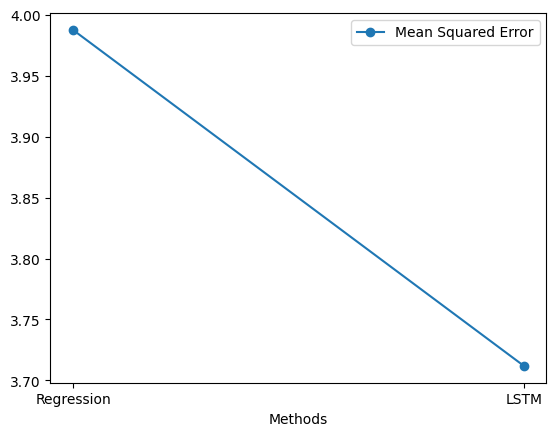

In [12]:
plt.plot(["Regression", "LSTM"], [3.9876557741635343, 3.7118978261947633], marker="o")
plt.legend(["Mean Squared Error"])
plt.xlabel("Methods")

### Method 1
Input: ..., Temp

Output: c(t+1)

In [9]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["Day"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Epoch 1/3


2023-06-07 17:30:20.846011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 17:30:20.847492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 17:30:20.848433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183178/183178 - 165s - loss: 3.9966 - accuracy: 0.3333 - 165s/epoch - 902us/step
Epoch 2/3
183178/183178 - 163s - loss: 3.8081 - accuracy: 0.3337 - 163s/epoch - 890us/step
Epoch 3/3
183178/183178 - 162s - loss: 3.7269 - accuracy: 0.3330 - 162s/epoch - 884us/step


2023-06-07 17:38:31.266878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 17:38:31.267918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 17:38:31.268954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/3
183010/183010 - 162s - loss: 3.6574 - accuracy: 0.3332 - 162s/epoch - 886us/step
Epoch 2/3
183010/183010 - 162s - loss: 3.6363 - accuracy: 0.3334 - 162s/epoch - 886us/step
Epoch 3/3
183010/183010 - 163s - loss: 3.6279 - accuracy: 0.3334 - 163s/epoch - 888us/step
Epoch 1/3
182982/182982 - 164s - loss: 3.6330 - accuracy: 0.3332 - 164s/epoch - 895us/step
Epoch 2/3
182982/182982 - 163s - loss: 3.6321 - accuracy: 0.3333 - 163s/epoch - 893us/step
Epoch 3/3
182982/182982 - 163s - loss: 3.6270 - accuracy: 0.3333 - 163s/epoch - 893us/step
Epoch 1/3
182971/182971 - 161s - loss: 3.6199 - accuracy: 0.3335 - 161s/epoch - 880us/step
Epoch 2/3
182971/182971 - 160s - loss: 3.6183 - accuracy: 0.3335 - 160s/epoch - 875us/step
Epoch 3/3
182971/182971 - 161s - loss: 3.6165 - accuracy: 0.3335 - 161s/epoch - 878us/step
Epoch 1/3
182971/182971 - 161s - loss: 3.6060 - accuracy: 0.3340 - 161s/epoch - 879us/step
Epoch 2/3
182971/182971 - 161s - loss: 3.6065 - accuracy: 0.3339 - 161s/epoch - 881us/step

### Method 2
Input: ..., Temp, ATemp

Output: c(t+1)

In [10]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["Day"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Epoch 1/3


2023-06-07 18:50:52.396987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 18:50:52.398022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 18:50:52.398714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183178/183178 - 160s - loss: 3.9623 - accuracy: 0.3337 - 160s/epoch - 876us/step
Epoch 2/3
183178/183178 - 159s - loss: 3.7794 - accuracy: 0.3332 - 159s/epoch - 866us/step
Epoch 3/3
183178/183178 - 160s - loss: 3.7173 - accuracy: 0.3329 - 160s/epoch - 872us/step


2023-06-07 18:58:51.358899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 18:58:51.359901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 18:58:51.360571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/3
183010/183010 - 158s - loss: 3.6619 - accuracy: 0.3331 - 158s/epoch - 865us/step
Epoch 2/3
183010/183010 - 160s - loss: 3.6386 - accuracy: 0.3332 - 160s/epoch - 872us/step
Epoch 3/3
183010/183010 - 160s - loss: 3.6231 - accuracy: 0.3337 - 160s/epoch - 876us/step
Epoch 1/3
182982/182982 - 160s - loss: 3.6296 - accuracy: 0.3334 - 160s/epoch - 873us/step
Epoch 2/3
182982/182982 - 158s - loss: 3.6258 - accuracy: 0.3333 - 158s/epoch - 861us/step
Epoch 3/3
182982/182982 - 159s - loss: 3.6215 - accuracy: 0.3332 - 159s/epoch - 866us/step
Epoch 1/3
182971/182971 - 160s - loss: 3.6168 - accuracy: 0.3335 - 160s/epoch - 874us/step
Epoch 2/3
182971/182971 - 159s - loss: 3.6081 - accuracy: 0.3336 - 159s/epoch - 868us/step
Epoch 3/3
182971/182971 - 159s - loss: 3.6103 - accuracy: 0.3335 - 159s/epoch - 869us/step
Epoch 1/3
182971/182971 - 158s - loss: 3.6089 - accuracy: 0.3339 - 158s/epoch - 866us/step
Epoch 2/3
182971/182971 - 159s - loss: 3.6055 - accuracy: 0.3340 - 159s/epoch - 868us/step

### Method 3
Input: ..., Temp, ATemp, Humidity

Output: c(t+1)

In [11]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["Day"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Epoch 1/3


2023-06-07 20:10:31.205251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:10:31.206531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:10:31.207296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183178/183178 - 165s - loss: 3.9611 - accuracy: 0.3332 - 165s/epoch - 901us/step
Epoch 2/3
183178/183178 - 163s - loss: 3.7784 - accuracy: 0.3337 - 163s/epoch - 890us/step
Epoch 3/3
183178/183178 - 163s - loss: 3.7596 - accuracy: 0.3335 - 163s/epoch - 889us/step


2023-06-07 20:18:42.487865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 20:18:42.489119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 20:18:42.489965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/3
183010/183010 - 165s - loss: 3.7341 - accuracy: 0.3334 - 165s/epoch - 900us/step
Epoch 2/3
183010/183010 - 163s - loss: 3.7284 - accuracy: 0.3333 - 163s/epoch - 890us/step
Epoch 3/3
183010/183010 - 164s - loss: 3.7213 - accuracy: 0.3330 - 164s/epoch - 898us/step
Epoch 1/3
182982/182982 - 164s - loss: 3.7354 - accuracy: 0.3327 - 164s/epoch - 897us/step
Epoch 2/3
182982/182982 - 164s - loss: 3.7248 - accuracy: 0.3325 - 164s/epoch - 894us/step
Epoch 3/3
182982/182982 - 164s - loss: 3.7270 - accuracy: 0.3324 - 164s/epoch - 894us/step
Epoch 1/3
182971/182971 - 163s - loss: 3.7219 - accuracy: 0.3323 - 163s/epoch - 893us/step
Epoch 2/3
182971/182971 - 164s - loss: 3.7159 - accuracy: 0.3323 - 164s/epoch - 897us/step
Epoch 3/3
182971/182971 - 165s - loss: 3.7142 - accuracy: 0.3319 - 165s/epoch - 903us/step
Epoch 1/3
182971/182971 - 164s - loss: 3.6934 - accuracy: 0.3323 - 164s/epoch - 895us/step
Epoch 2/3
182971/182971 - 164s - loss: 3.6551 - accuracy: 0.3337 - 164s/epoch - 898us/step

### Method 4
Input: ..., Temp, ATemp, Humidity, WeatherSituation

Output: c(t+1)

In [ ]:
dataset = pd.get_dummies(data=dataset, columns=["WeatherSituation"], dtype=int)

In [22]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "WeatherSituation_1.0", "WeatherSituation_2.0", "WeatherSituation_3.0", "WeatherSituation_4.0", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["Day"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Epoch 1/3


2023-06-09 09:10:44.203251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 09:10:44.205051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-09 09:10:44.205835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183178/183178 - 178s - loss: 3.9929 - accuracy: 0.3336 - 178s/epoch - 974us/step
Epoch 2/3
183178/183178 - 189s - loss: 3.7760 - accuracy: 0.3335 - 189s/epoch - 1ms/step
Epoch 3/3
183178/183178 - 174s - loss: 3.7089 - accuracy: 0.3332 - 174s/epoch - 952us/step


2023-06-09 09:19:46.087408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 09:19:46.088883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-09 09:19:46.089734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/3
183010/183010 - 167s - loss: 3.6548 - accuracy: 0.3332 - 167s/epoch - 915us/step
Epoch 2/3
183010/183010 - 167s - loss: 3.6285 - accuracy: 0.3332 - 167s/epoch - 915us/step
Epoch 3/3
183010/183010 - 166s - loss: 3.6154 - accuracy: 0.3333 - 166s/epoch - 909us/step
Epoch 1/3
182982/182982 - 167s - loss: 3.6211 - accuracy: 0.3330 - 167s/epoch - 911us/step
Epoch 2/3
182982/182982 - 167s - loss: 3.6117 - accuracy: 0.3331 - 167s/epoch - 911us/step
Epoch 3/3
182982/182982 - 166s - loss: 3.6050 - accuracy: 0.3332 - 166s/epoch - 908us/step
Epoch 1/3
182971/182971 - 177s - loss: 3.6041 - accuracy: 0.3335 - 177s/epoch - 968us/step
Epoch 2/3
182971/182971 - 176s - loss: 3.6016 - accuracy: 0.3336 - 176s/epoch - 959us/step
Epoch 3/3
182971/182971 - 187s - loss: 3.5998 - accuracy: 0.3337 - 187s/epoch - 1ms/step
Epoch 1/3
182971/182971 - 174s - loss: 3.5967 - accuracy: 0.3340 - 174s/epoch - 954us/step
Epoch 2/3
182971/182971 - 171s - loss: 3.5927 - accuracy: 0.3342 - 171s/epoch - 934us/step
E

### Method 5
Input: ..., Temp, ATemp, Humidity, WeatherSituation, Windspeed

Output: c(t+1)

In [23]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "WeatherSituation_1.0", "WeatherSituation_2.0", "WeatherSituation_3.0", "WeatherSituation_4.0", "Humidity", "Windspeed"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["Day"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Epoch 1/3


2023-06-09 10:36:34.315882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 10:36:34.317220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-09 10:36:34.318096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183178/183178 - 169s - loss: 3.9868 - accuracy: 0.3337 - 169s/epoch - 923us/step
Epoch 2/3
183178/183178 - 159s - loss: 3.8030 - accuracy: 0.3338 - 159s/epoch - 867us/step
Epoch 3/3
183178/183178 - 159s - loss: 3.7753 - accuracy: 0.3336 - 159s/epoch - 867us/step


2023-06-09 10:44:41.300825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 10:44:41.302004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-09 10:44:41.302822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/3
183010/183010 - 166s - loss: 3.7378 - accuracy: 0.3336 - 166s/epoch - 906us/step
Epoch 2/3
183010/183010 - 166s - loss: 3.7305 - accuracy: 0.3337 - 166s/epoch - 908us/step
Epoch 3/3
183010/183010 - 164s - loss: 3.7298 - accuracy: 0.3338 - 164s/epoch - 896us/step
Epoch 1/3
182982/182982 - 158s - loss: 3.7379 - accuracy: 0.3337 - 158s/epoch - 865us/step
Epoch 2/3
182982/182982 - 158s - loss: 3.7308 - accuracy: 0.3338 - 158s/epoch - 866us/step
Epoch 3/3
182982/182982 - 159s - loss: 3.7301 - accuracy: 0.3337 - 159s/epoch - 870us/step
Epoch 1/3
182971/182971 - 163s - loss: 3.7264 - accuracy: 0.3339 - 163s/epoch - 890us/step
Epoch 2/3
182971/182971 - 153s - loss: 3.7288 - accuracy: 0.3339 - 153s/epoch - 834us/step
Epoch 3/3
182971/182971 - 160s - loss: 3.7256 - accuracy: 0.3339 - 160s/epoch - 872us/step
Epoch 1/3
182971/182971 - 173s - loss: 3.7234 - accuracy: 0.3343 - 173s/epoch - 944us/step
Epoch 2/3
182971/182971 - 171s - loss: 3.7269 - accuracy: 0.3342 - 171s/epoch - 933us/step

## Graphs

Text(0.5, 0, 'Methods')

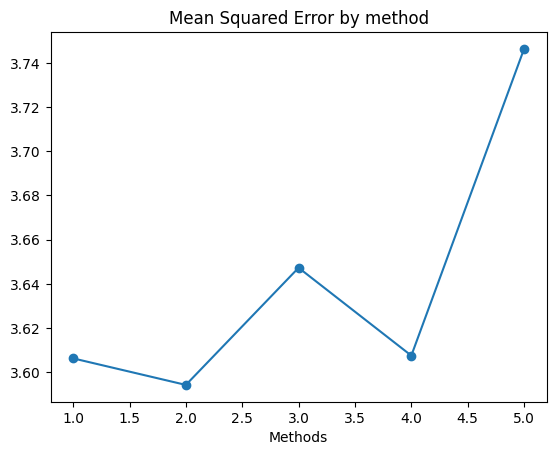

In [25]:
plt.plot(list(range(1,len(MSE)+1)), MSE, marker="o")
plt.title("Mean Squared Error by method")
plt.xlabel("Methods")

Text(0.5, 0, 'Methods')

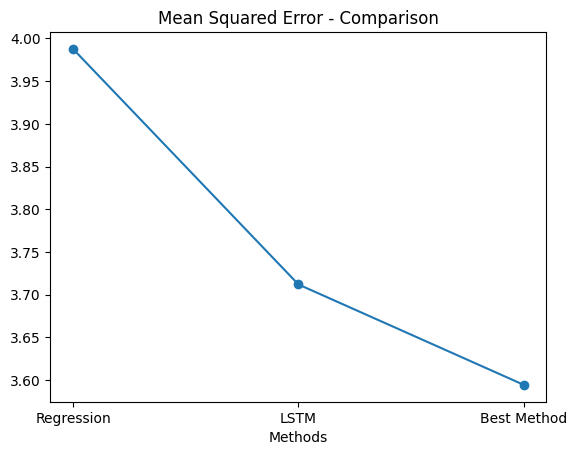

In [26]:
plt.plot(["Regression", "LSTM", "Best Method"], [3.9876557741635343, 3.7118978261947633, 3.5943119287490846], marker="o")
plt.title("Mean Squared Error - Comparison")
plt.xlabel("Methods")